In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
import tensorflow as tf
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x, W) + b)

In [5]:
yt = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(yt * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [6]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, yt: batch_ys})

In [7]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(yt,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, yt: mnist.test.labels}))

0.9124


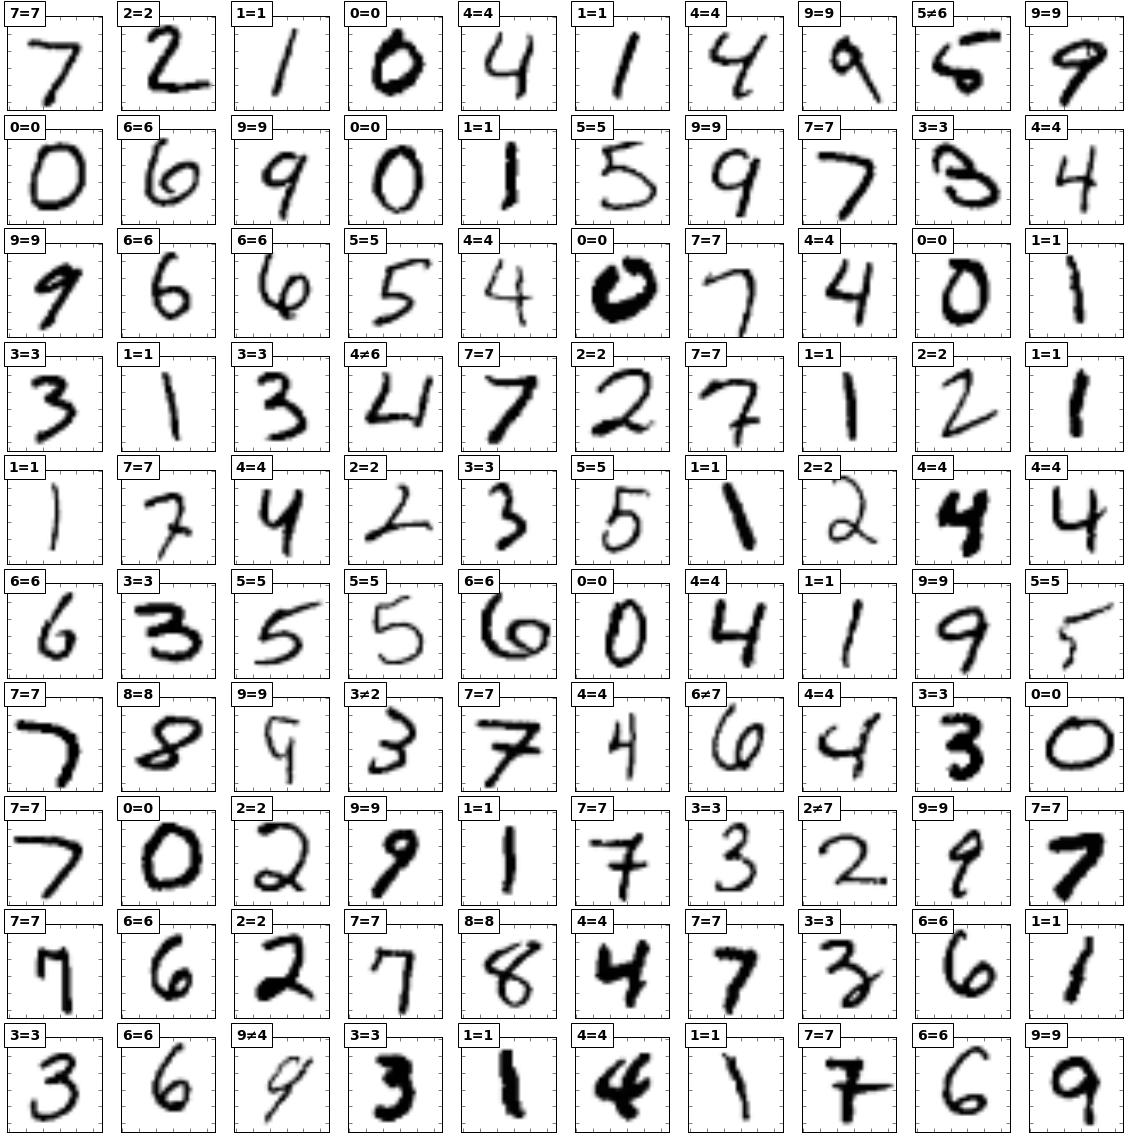

In [8]:
num_rows, num_cols = 10, 10
width, height = num_cols * 2, num_rows * 2
fig = plt.figure(figsize=(width, height))

for i in range(0, 100):
    ax = fig.add_subplot(num_rows, num_cols, i+1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    image = mnist.test.images[i].reshape((28, 28))
    label = mnist.test.labels[i].argmax()
    prediction = sess.run(y, feed_dict={x: mnist.test.images[i:i+1]}).argmax()
    ax.imshow(image, cmap='Greys')
    text = u'%i=%i'%(label, prediction) if label==prediction else u'%i≠%i'%(label, prediction)
    ax.text(0, 0, text, bbox={'facecolor':'white', 'pad':5}, fontdict={'size':14, 'weight': 'bold'})

In [11]:
mnist.test.labels.shape

(10000, 10)